In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --- 1. Load and Preprocess the Dataset ---

In [2]:
# Read the data that is inside of the CSV
df = pd.read_csv("./Health_Data/cleaned_health.csv")
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3
0,52,1,125,212,0,1,168,0,1.0,2,2,3,0,1,0,0,0
1,53,1,140,203,1,0,155,1,3.1,0,0,3,0,1,0,0,0
2,70,1,145,174,0,1,125,1,2.6,0,0,3,0,1,0,0,0
3,61,1,148,203,0,1,161,0,0.0,2,1,3,0,1,0,0,0
4,62,0,138,294,1,1,106,0,1.9,1,3,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,68,0,120,211,0,0,115,0,1.5,1,0,2,1,0,0,1,0
298,44,0,108,141,0,1,175,0,0.6,1,0,2,1,0,0,1,0
299,52,1,128,255,0,1,161,1,0.0,2,1,3,0,1,0,0,0
300,59,1,160,273,0,0,125,0,0.0,2,0,2,0,0,0,0,1


In [3]:
# --- Configuration ---
TARGET_COL = 'target'

# Define numerical columns for imputation and outlier detection
NUMERICAL_FEATURES = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
CATEGORICAL_FEATURES = ['sex', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [4]:
# Handle '?' or other non-numeric values, converting to NaN
df.replace(['?', 'N/A'], np.nan, inplace=True)

# Convert all relevant columns to numeric, coercing errors
for col in NUMERICAL_FEATURES + CATEGORICAL_FEATURES + [TARGET_COL]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing numerical values with the median
for col in NUMERICAL_FEATURES:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with its median ({median_val}).")
        
# Impute missing categorical/target values with the mode
for col in CATEGORICAL_FEATURES + [TARGET_COL]:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with its mode ({mode_val}).")

# Create a copy for analysis to avoid modifying the original data
df_outlier_analysis = df.copy()

print("\nInitial data distribution for key numerical features:")
print(df_outlier_analysis[NUMERICAL_FEATURES].describe())


Initial data distribution for key numerical features:
             age    trestbps        chol     thalach     oldpeak
count  302.00000  302.000000  302.000000  302.000000  302.000000
mean    54.42053  131.602649  246.500000  149.569536    1.043046
std      9.04797   17.563394   51.753489   22.903527    1.161452
min     29.00000   94.000000  126.000000   71.000000    0.000000
25%     48.00000  120.000000  211.000000  133.250000    0.000000
50%     55.50000  130.000000  240.500000  152.500000    0.800000
75%     61.00000  140.000000  274.750000  166.000000    1.600000
max     77.00000  200.000000  564.000000  202.000000    6.200000


# --- 2. Outlier Detection ---


--- Outlier Detection with Boxplots and the IQR Method ---


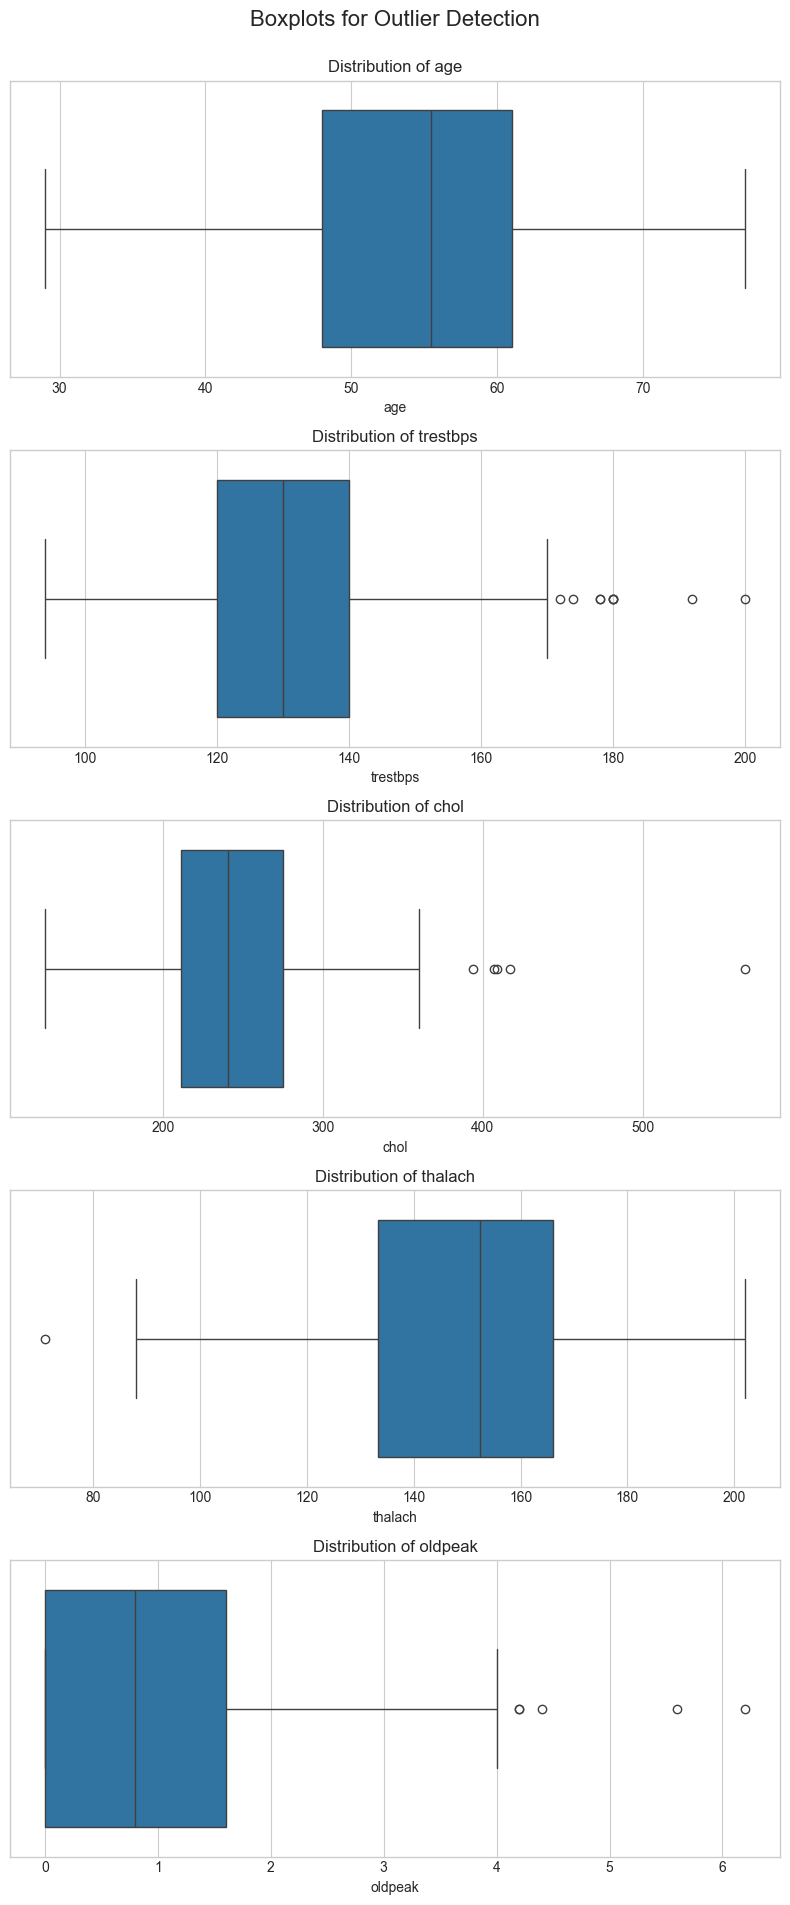


Outliers detected using the IQR method:
  -> 'age': Found 0 outlier(s).
  -> 'trestbps': Found 9 outlier(s).
  -> 'chol': Found 5 outlier(s).
  -> 'thalach': Found 1 outlier(s).
  -> 'oldpeak': Found 5 outlier(s).


In [5]:
print("\n--- Outlier Detection with Boxplots and the IQR Method ---")

# Plotting boxplots to visually identify outliers
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(nrows=len(NUMERICAL_FEATURES), ncols=1, figsize=(8, 4 * len(NUMERICAL_FEATURES)))
fig.suptitle('Boxplots for Outlier Detection', fontsize=16)

for i, col in enumerate(NUMERICAL_FEATURES):
    if col in df_outlier_analysis.columns:
        sns.boxplot(x=df_outlier_analysis[col], ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Using the IQR method to quantitatively identify outliers
def find_outliers_iqr(data, col):
    """Finds outliers using the Interquartile Range (IQR) method."""
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    
    outliers = data[(data[col] < lower_fence) | (data[col] > upper_fence)]
    return outliers

print("\nOutliers detected using the IQR method:")
outlier_summary = {}
for col in NUMERICAL_FEATURES:
    if col in df_outlier_analysis.columns:
        outliers = find_outliers_iqr(df_outlier_analysis, col)
        outlier_summary[col] = len(outliers)
        print(f"  -> '{col}': Found {len(outliers)} outlier(s).")
        # print(outliers[[col, TARGET_COL]]) # Uncomment to see the outlier rows

# --- 3. Outlier Handling Strategies ---

In [6]:
print("\n--- Outlier Handling Strategies ---")

# Strategy 1: Capping (or Winsorizing) the outliers
df_capped = df_outlier_analysis.copy()
print("\nApplying Capping to Outliers...")

def cap_outliers_iqr(data, col):
    """Caps outliers with the IQR method's fences."""
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - (1.5 * IQR)
    upper_fence = Q3 + (1.5 * IQR)
    
    # Cap values that are below the lower fence
    data.loc[data[col] < lower_fence, col] = lower_fence
    # Cap values that are above the upper fence
    data.loc[data[col] > upper_fence, col] = upper_fence
    return data

for col in NUMERICAL_FEATURES:
    if col in df_capped.columns:
        df_capped = cap_outliers_iqr(df_capped, col)
print("Outliers capped in a new DataFrame 'df_capped'.")
print("New distribution for 'chol' after capping:")
print(df_capped['chol'].describe())


--- Outlier Handling Strategies ---

Applying Capping to Outliers...
Outliers capped in a new DataFrame 'df_capped'.
New distribution for 'chol' after capping:
count    302.000000
mean     245.377070
std       47.486683
min      126.000000
25%      211.000000
50%      240.500000
75%      274.750000
max      370.375000
Name: chol, dtype: float64


In [7]:
# Strategy 2: Removing the outliers
df_removed = df_outlier_analysis.copy()
print("\nApplying Removal of Outliers...")

# Get the indices of all outliers combined
outlier_indices = set()
for col in NUMERICAL_FEATURES:
    if col in df_removed.columns:
        outliers = find_outliers_iqr(df_removed, col)
        outlier_indices.update(outliers.index)

print(f"Total number of outlier rows to remove: {len(outlier_indices)}")
df_removed.drop(index=list(outlier_indices), inplace=True)
print(f"Outliers removed. Original shape: {df_outlier_analysis.shape}, New shape: {df_removed.shape}")


Applying Removal of Outliers...
Total number of outlier rows to remove: 19
Outliers removed. Original shape: (302, 17), New shape: (283, 17)


# --- 4. Comparison of Distributions ---


--- Comparing Distributions Before and After Handling ---


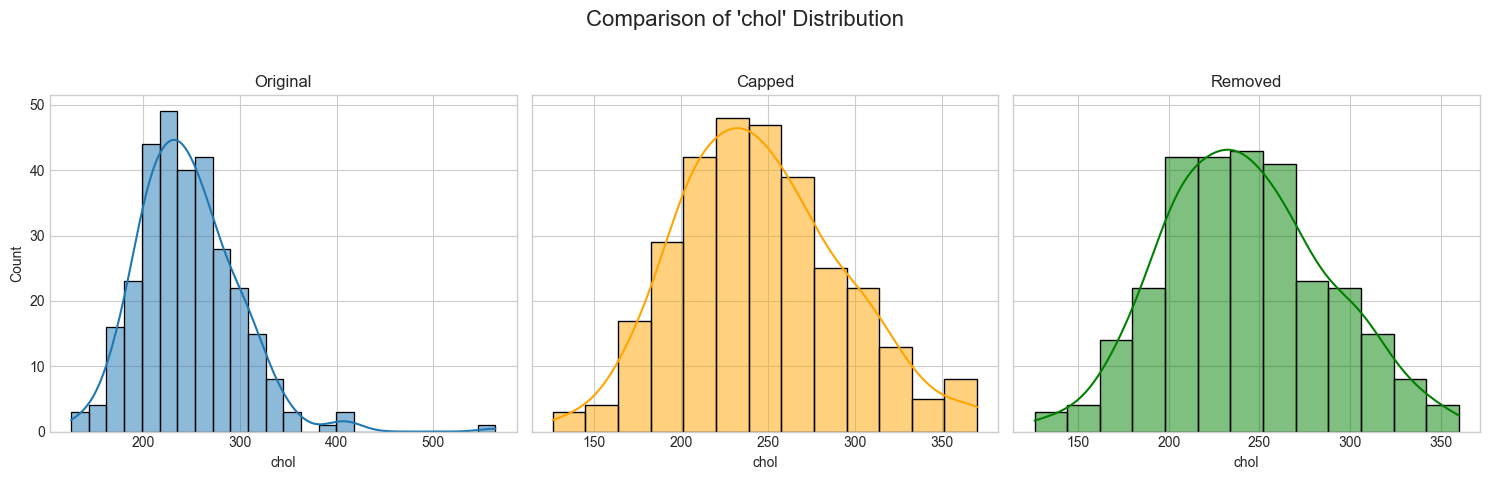

In [8]:
print("\n--- Comparing Distributions Before and After Handling ---")

# Plotting a single feature for comparison
feature_to_compare = 'chol'
if feature_to_compare in df_outlier_analysis.columns:
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(f"Comparison of '{feature_to_compare}' Distribution", fontsize=16)

    # Original Distribution
    sns.histplot(df_outlier_analysis[feature_to_compare], ax=axes[0], kde=True)
    axes[0].set_title("Original")
    
    # Capped Distribution
    sns.histplot(df_capped[feature_to_compare], ax=axes[1], kde=True, color='orange')
    axes[1].set_title("Capped")

    # Removed Distribution
    sns.histplot(df_removed[feature_to_compare], ax=axes[2], kde=True, color='green')
    axes[2].set_title("Removed")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print(f"Cannot compare distribution for '{feature_to_compare}': Column not found.")

In [9]:
print("\nDeep dive into outliers complete. You now have two cleaned DataFrames: 'df_capped' and 'df_removed'. You can use these for further modeling steps.")


Deep dive into outliers complete. You now have two cleaned DataFrames: 'df_capped' and 'df_removed'. You can use these for further modeling steps.
